In [91]:
import numpy as np
import matplotlib.pyplot as plt
import get_data as gd
import Preprocessing as p
import SimpleITK as sitk
import seaborn as sns
from scipy import stats, signal

In [8]:
def create_dataframe(folder_path, image_prefix, mask_suffix):
    """
    Returns a dataframe with information of the images in the folder_path
    
    folder_path: path to folder with images
    image_prefix: prefix of image files
    mask_suffix: suffix of mask files
    """
    patientPaths, patientNames, imagePaths, maskPaths = gd.get_paths(folder_path, image_prefix, mask_suffix)
    df = p.dataframe(patientPaths, patientNames, imagePaths, maskPaths)
    df = p.dimensions(df)
    return df

In [20]:
def intensities(df):
    """
    Returns a list of arrays containing the pixel intensities of the images in the dataframe
    
    df: dataframe with image paths
    """
    
    pixel_values = []
    
    for path in df['imagePaths']:
        print(path)
        image = sitk.ReadImage(path)
        image_array = sitk.GetArrayFromImage(image)
        pixel_values.append(image_array.flatten())
    
    return pixel_values

In [204]:
def pixel_distribution(pixel_list):
    """
    Plots the distribution of pixels in the images 
    """
    fig, ax = plt.subplots(figsize=(11,8))
    for i in range(len(pixel_list)):
        sns.kdeplot(data=pixel_list[i], ax=ax)
    plt.show()

In [9]:
Oxy = create_dataframe('/Volumes/LaCie/MasterThesis_Ingvild/Oxy_cropped', 'T2', 'an.nii')

In [196]:
Oxy_train = Oxy[:3]
pixel_values = intensities(Oxy_train)

/Volumes/LaCie/MasterThesis_Ingvild/Oxy_cropped/Oxytarget_103_PRE/T2.nii
/Volumes/LaCie/MasterThesis_Ingvild/Oxy_cropped/Oxytarget_106_PRE/T2.nii
/Volumes/LaCie/MasterThesis_Ingvild/Oxy_cropped/Oxytarget_108_PRE/T2.nii


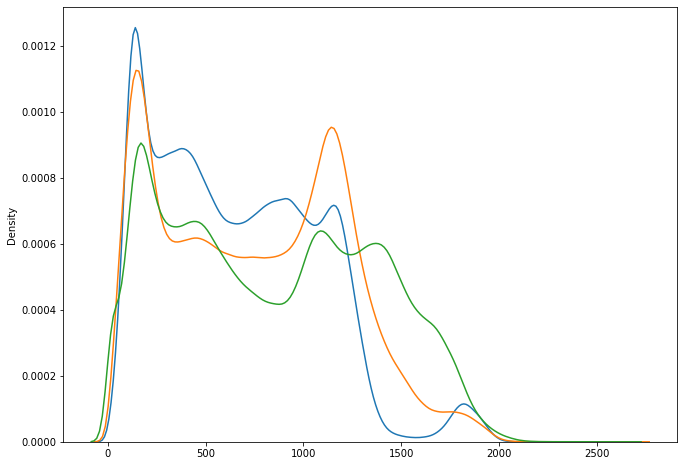

In [205]:
pixel_distribution(pixel_values)

In [216]:
def landmarks(pixel_list, min_percentile, max_percentile):
    """
    Returns the minimum and maximum percentile values (p_1j, p_2j) for image j.
    """
    min_percentiles = []
    max_percentiles = []
    bimodals = []
    
    for i in range(len(pixel_list)):
        min_percentiles.append(np.percentile(pixel_list[i], min_percentile))
        max_percentiles.append(np.percentile(pixel_list[i], max_percentile))
        
        max_y = []
        x,y = sns.kdeplot(pixel_list[i]).get_lines()[0].get_data()
        max_index = np.ndarray.tolist(signal.argrelextrema(y, np.greater)[0])
        for j in max_index:
            max_y.append(y[j])
        print(max_y)
        print(max_y.sort())
        bimodal_j = x[np.where(y==max_y[-2])]
        bimodals.append(bimodal_j)
        x = None
        y = None
    return min_percentiles, max_percentiles, bimodals

[0.001255695236437258, 0.0008889327346748238, 0.0007371869132722369, 0.0007171009050593716, 0.00011487081518617746]
None
[0.001255695236437258, 0.0008889327346748238, 0.0007371869132722369, 0.0007171009050593716, 0.00011487081518617746]
None
[0.001255695236437258, 0.0008889327346748238, 0.0007371869132722369, 0.0007171009050593716, 0.00011487081518617746]
None
[0.0, 0.0, 0.0]
[1928.8669108669073, 1933.4915750915723, 1983.3238095238091]
[array([377.70752382]), array([377.70752382]), array([377.70752382])]


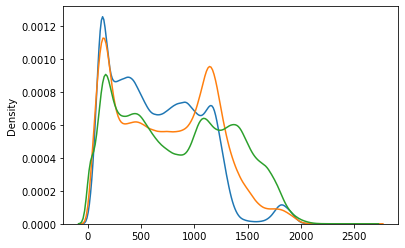

In [217]:
min_p, max_p, bimodals = landmarks(pixel_values, 0, 99.8)
print(min_p)
print(max_p)
print(bimodals)